<h1 style="font-size:300%">Inventory Management Kika Group Ltd.</h1>

In this notebook a forecasting model, that will predict future sales based on various aspects, will be built. The model will allow the company to:

1. Automatically predict when stock levels will run low for fast-selling products.
2. Optimize restocking schedules based on expected demand.
3. Reduce stockouts and prevent lost sales due to unavailability.
4. Minimize excess inventory for slow-moving products, reducing storage costs.

<img src="images\K-logo.png" width="150px" height="150px" alt="Kika Logo">

Kika Group Ltd. currently operates with [ERP.net](https://erp.net/), where they store all of their data since they started business. From stock inventory and sales to all of their customers, this application is very crucial for the company. An access to this application has been given to the developers of this model and gahtering data throughout all iterations is going to be done from there.

As a more B2B (business to business) oriented brand and being known in over 60 countries, the company faces many challenges, some of which are stockouts, lost sales due to unavailability, excessive inventory for slow-moving products and many more.

That is why with this model we will solve some of their problems regarding their stock management.

# 📚 Libraries and their version

First and foremost we should report the libraries that are going to be used in this notebook.

In [280]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


print("scikit-learn version:", sklearn.__version__)     # 1.6.1
print("pandas version:", pd.__version__)            # 2.2.3
print("seaborn version:", sns.__version__)          # 0.13.2

scikit-learn version: 1.6.1
pandas version: 2.2.3
seaborn version: 0.13.2


<h1 style="font-size:300%">Iteration 2 - Work</h1>

During Iteration 1, we made significant improvements across all areas of the project—from Exploratory Data Analysis (EDA) to Model Engineering. By correcting our dataset and properly analyzing trends and spikes, we uncovered the true potential of our AI model.

The main objective for this iteration is to build upon the progress made previously and take the next step toward delivering a reliable, product-level demand forecasting model.

To achieve this, we will follow a structured approach—starting from Data Provisioning and moving through each critical step, just as we did in the earlier iterations, to ensure accuracy and consistency in our results.

# 📦 Data Provisioning

Once again, we will begin by loading our previous sales dataset, which proved effective in the last iteration. To enhance our model and reach our current goals, we will introduce an additional dataset containing the stock levels of all products.

By combining these two datasets, we aim to generate more accurate and actionable demand forecasts.

In [281]:
sales_data = pd.read_csv("sales_strollers_01012023_01012025_new.csv", encoding="utf-8", delimiter=";")
sales_data.sample(5)

,Customer,Product Description,Document Date,Document Type,Document No,Product Group,Product,Quantity,Quantity Unit,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Sales Order,Sales Person,Customer Sales Person,Sales Person Group Name
11641,KIKKABOO ESPANA S.L.,Stroller 2in1 with hard carrycot Amani Mint,27.1.2023,Invoice,3710051929,100102: Kombinirani bebeshki kolichki 2 v 1,31001020127,5,pcs,5,"320,26222","1441,18",EUR,"2818,7",042:1710110958 - Porachka ot klient bez DDS,SVETOSLAV NICHINKOV,SVETOSLAV NICHINKOV,Пловдив
7341,HIPOLEND AD,Autofolding pushchair Eden Black,12.1.2024,Invoice,3710063790,100103: Bebeshki letni kolichki,31001030154,1,pcs,1,"145,71","145,71",BGN,"145,71",041:1710139190 - Porachka ot klient,SABIHA KOTALAK,SABIHA KOTALAK,Пловдив
16126,OZONE ENTERTAINMENT JSC,Twin stroller Happy 2 Black 2023,12.4.2024,Invoice,3710066928,100104: Bebeshki kolichki za bliznatsi,31001040012,1,pcs,1,"276,11579","262,31",BGN,"262,31",041:1710146745 - Porachka ot klient,SABIHA KOTALAK,SABIHA KOTALAK,Пловдив
858,ALMUKHTALIF GROUP,Pushchair Alexa Light Grey,20.9.2024,Invoice,3710072152,100103: Bebeshki letni kolichki,31001030181,4,pcs,4,"62,27","249,08",EUR,"487,16",042:1710157783 - Porachka ot klient bez DDS,SEVIM ALIEVA MUSTAFOVA - PETROVA,SEVIM ALIEVA MUSTAFOVA - PETROVA,Външен пазар
8503,HIPOLEND AD,Pushchair Libro Light Grey 2020,22.3.2023,Credit Note,3710053522,100103: Bebeshki letni kolichki,31001030099,-1,pcs,-1,"127,29","-127,29",BGN,"-127,29",054:1710007215 - Return goods,SVETOSLAV NICHINKOV,SABIHA KOTALAK,Пловдив


Now it is of most importance that we actually understand what is going on with the dataset. A step that we missed in the previous iteration so in this one, before we get to actual modelling we are going to first pay huge attention to every single column of the dataset.

In [282]:
print(sales_data.columns.to_list())

['Customer', 'Product Description', 'Document Date', 'Document Type', 'Document No', 'Product Group', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base', 'Unit Price', 'Line Amount', 'Document Currency', 'Line Amount In Base Currency', 'Sales Order', 'Sales Person', 'Customer Sales Person', 'Sales Person Group Name']


First off the immediate columns to drop are  *`Customer`*(for this iteration we do not need it, but we might use to for later iterations for market segmentation) *`Quantity Unit`*(because it is always pcs), *`Sales Order`*(internal order reference, which may be good for joining other systems, but at the moment we do not need it), *`Sales Person`*(other than analyzing salesperson performance for forecasting it is unnecessary), *`Customer Sales Person`*, and maybe *`Sales Person Group Name`*(which at the moment may not be supportive unless we forecast by region also). But before we extract the important info from this dataset, let's see their types of data that each column holds. 

Also if **`"Quantity Unit"`** has only `"pcs"` as value we should also consider dropping it.

Also another column we should pay attention is the `Document Type`, which we are going to analyze later on.

In [283]:
sales_data["Quantity Unit"].unique()

array(['pcs'], dtype=object)

As we can see `"pcs"` is the only value in that column and because it won't help us in any way we will include in the columns that we are going to drop.

In [284]:
sales_data.drop(columns=[
    'Customer',
    'Quantity Unit',
    'Sales Order',
    'Document No',
    'Sales Person',
    'Customer Sales Person',
    'Sales Person Group Name'
], inplace=True)

Now that we have dropped all the immediately noticeable unusefull columns, let's have a closer look into the `Document Type` column.

In [285]:
sales_data['Document Type'].unique()

array(['Invoice', 'Credit Note', 'Stokovo-parichen otchet',
       'Stokovo-parichen otchet za ES', 'Debit Note',
       'Stokovo-parichen otchet Onlayn magazin BG'], dtype=object)

Because I am going to drop the other rows other than the "Invoice" one and I do not want to translate the rows inside the dataset, I am going to translate every unique value and I am going to explain why we do not need them. Please note that all of the values were explained by the stakeholder and all of our actions are according to his assumptions.

1. *`Credit Note`* - A return or refund issued to a customer. Currently for this iteration it may be not smart to include customer returns, BUT if we have time for a more advanced model later, we can definetely explore incorporation.
2. *`"Stokovo-parichen otchet"`* or *`Stock-money report`* - this is a stock-money report our stakeholder makes and alone said we do not need it for the model.
3. *`Stokovo-parichen otchet za ES`* or *`Stock-money report for EU`* - same as above, but from all european sales
4. *`Stokovo-parichen otchet Onlayn magazin BG`* or *`Stock-money report for Online Webshop`* - same as above, but only from online shop

But before we drop them let's analyze the total rows we have in store and after we drop other rows (others different than `Invoices`) we will see if it indeed appropriate to drop them or not (if the dataset changed drastically).

In [286]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22251 entries, 0 to 22250
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           22251 non-null  object
 1   Document Date                 22251 non-null  object
 2   Document Type                 22251 non-null  object
 3   Product Group                 22251 non-null  object
 4   Product                       22251 non-null  int64 
 5   Quantity                      22251 non-null  int64 
 6   Quantity Base                 22251 non-null  int64 
 7   Unit Price                    22251 non-null  object
 8   Line Amount                   22251 non-null  object
 9   Document Currency             22251 non-null  object
 10  Line Amount In Base Currency  22251 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [287]:
sales_data = sales_data[sales_data['Document Type'] == 'Invoice'].reset_index(drop=True)

In [288]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           20602 non-null  object
 1   Document Date                 20602 non-null  object
 2   Document Type                 20602 non-null  object
 3   Product Group                 20602 non-null  object
 4   Product                       20602 non-null  int64 
 5   Quantity                      20602 non-null  int64 
 6   Quantity Base                 20602 non-null  int64 
 7   Unit Price                    20602 non-null  object
 8   Line Amount                   20602 non-null  object
 9   Document Currency             20602 non-null  object
 10  Line Amount In Base Currency  20602 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.7+ MB


As we can see, removing all rows that are not labeled as "Invoices" reduced the dataset by exactly 1,649 entries, which represents approximately 7% of the total data. This indicates that have no problem continuing our work with this particular dataset. And now that we are left with only the invoices, we should not bother keeping this column and we can also drop it, as it does not bring any correlation as well.

In [289]:
sales_data.drop(columns=[
    'Document Type',
], inplace=True)

Now next columns to be analyzed and to see how they differ are the `Unit Price`, `Line Amount`, `Line Amount In Base Currency` and `Currency`. 
1. The unit price is the price per unit of the actual product. If the quantity is 1, then the unit price will be equal to the line amount or almost equivalent, because some invoices have discounts recorder (according to our stakeholder).
2. Line amount is the total revenue of the invoice that the sales employee registers (Unit Price x Quantity) in the currency mentioned in the next column.
3. Line Amount In Base Currency is the monetary value of the sale expressed in Kika's default currency — BGN in our case (Bulgarian Lev).

Note that even when Quantity = 1, we should rely on the Line Amount In Base Currency, because it is in BGN and its the currency that the company operates in.

The Unit Price becomes less reliable for modeling revenue or demand — it's more of a reference, not a guaranteed source of truth.

In [290]:
sales_data['Document Currency'].unique()  

array(['BGN', 'EUR', 'USD'], dtype=object)

Now we can see that there are invoices with different currencies, but as we mentioned earlier `Line Amount In Base Currency` comes to our help and we do not need to manually calculate the revenue in one currency, which is done in that column. So for all the reasons above we are going to remove the `Unit Price`, `Line Amount` and `Currency`, so that we are left with only one column regarding the revenue and that way we are not causing any confusions. Also from the initial table at the start we can see that the values are

In [291]:
sales_data.drop(columns=['Unit Price', 'Line Amount', 'Document Currency'], inplace=True)
sales_data.rename(columns={'Line Amount In Base Currency': 'Revenue in BGN'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"


Now that we are coming close to our desired and well-cleaned dataset two more columns should be immediately studied and those are the `Quantity` and `Quantity Base`. From the first 5 rows it seems that there are the same, but let's actually check. 

In [292]:
difference = (sales_data['Quantity'] != sales_data['Quantity Base']).sum()
print(f"Rows where Quantity and Quantity Base differ: {difference}")

Rows where Quantity and Quantity Base differ: 0


The above result means we can safely drop one of them, and by convention, it’s cleaner to keep the standardized one — usually `Quantity Base`.

In [293]:
sales_data.drop(columns=[
    'Quantity',
], inplace=True)

In [294]:
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Also the Product column should be renamed as it holds not the actual name of the product, but as the stakeholder explained it is their SKU (stock keeping unit) number, with which they track and store all of their products. One could also ask why do we need both the names and their SKU of the products and I would simply say that:

- SKU serves as the unique product identifier and is essential for all core operations, including merging datasets and making product-level predictions.

- Product Description is kept to improve readability and visualization, making it easier to interpret results during analysis. Additionally, it may prove useful for handling future tasks such as clustering, grouping, or enriching the data with external sources.

In [295]:
sales_data.rename(columns={'Product': 'SKU'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Now that we have analyzed all the columns, excluded irrelevant ones and kept the others, we should now pay attention to their data types as for the model, this step is crucial.

In [296]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Product Description  20602 non-null  object
 1   Document Date        20602 non-null  object
 2   Product Group        20602 non-null  object
 3   SKU                  20602 non-null  int64 
 4   Quantity Base        20602 non-null  int64 
 5   Revenue in BGN       20602 non-null  object
dtypes: int64(2), object(4)
memory usage: 965.8+ KB


As we can see there are 20602 rows, which is not that bad and even more good is that there are no empty values (there are no rows with some empty column values). 

First we have the Document Date we shoud convert it to `datetime` so we can sort by time, group by week/month/year, resample, plot trends and forecast properly.

The `Revenue in BGN` needs to be float with commas instead of dots.

The rest columns are their appropriate data type.

Let's now commence with the data cleaning and processing the data and first convert all the columns we said that they need to be converted.

In [297]:
sales_data['Document Date'] = pd.to_datetime(
    sales_data['Document Date'],
    format='%d.%m.%Y',     # day.month.year format
    errors='coerce'        # invalid formats become NaT
)

sales_data['Document Date'].head()

0   2024-10-29
1   2024-06-18
2   2024-03-26
3   2024-06-18
4   2024-04-23
Name: Document Date, dtype: datetime64[ns]

In [298]:
cols_to_clean = ['Revenue in BGN']

for col in cols_to_clean:
    sales_data[col] = sales_data[col].str.replace(',', '.', regex=False)
    sales_data[col] = sales_data[col].astype(float)

In [299]:
sales_data.dtypes

Product Description            object
Document Date          datetime64[ns]
Product Group                  object
SKU                             int64
Quantity Base                   int64
Revenue in BGN                float64
dtype: object

Now that we have converted **`date`** to an appropriate data type we should combine into, which would not only help us visualize trends, but also because during iteration 0 that sales data had individual rows for each sale transaction (per product, per date) and we used those individual transactions as rows, we added time-based features like *`month`*, *`week`*, *`day_of_week`*, BUT we did not group or structure the data per stroller model over time. 

In other words we missed the "time series per product" structure meaning, we did not actually aggregate daily sales per stroller. That led to the model treating each sale as an isolated event and not taking into consideration the same stroller sold over time. Therefore it couldn't learn product-specific trends, just general patterns across that dataset. 

That is why to avoid confusing the model we are going to create the `monthly_sales` DataFrame to transform detailed transaction-level data into a summarized time series format, where each row represents monthly sales per product (SKU).

That way we:
- Instead of working with thousands of individual invoices, we now have 1 row per SKU per month.
- Much easier for training a demand forecasting model.
- We can now add lag values, rolling averages, seasonal effects, and trend indicators.
- We get total units sold and total revenue for each product per month.

In [300]:
sales_data.sort_values('Document Date', inplace=True)
sales_data['Month'] = sales_data['Document Date'].dt.to_period('M').dt.to_timestamp()
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN,Month
15182,Stroller 3in1 transf. seat Beloved Dark Grey,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010118,1,285.14,2023-01-01
8010,Pushchair Juno Beige 2020,2023-01-04,100103: Bebeshki letni kolichki,31001030107,1,127.29,2023-01-01
2642,Stroller 2in1 with carrycot Thea Dark Grey,2023-01-04,100102: Kombinirani bebeshki kolichki 2 v 1,31001020110,1,541.59,2023-01-01
14751,Pushchair Beetle Beige,2023-01-04,100103: Bebeshki letni kolichki,31001030077,1,79.43,2023-01-01
425,Stroller 3in1 Madrid Mint Melange 2020,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010135,1,416.07,2023-01-01


In [301]:
monthly_sales = (
    sales_data
    .groupby(['SKU', 'Product Description', 'Product Group', 'Month'])
    .agg(
        Quantity=('Quantity Base', 'sum'),
        Revenue=('Revenue in BGN', 'sum')
    )
    .reset_index()
)

monthly_sales.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36


This format is ideal when we want to predict future monthly demand per product.

Now that we applied all cleaning methods with the additional comments to the sales dataset we are left with our *NEW* dataset of the stock level of the products. Let's use the same cleaning methods to this dataset also.

In [320]:
stock_level = pd.read_csv("stock_level_strollers_01012025.csv", encoding="utf-8", delimiter=";")
stock_level.sample(5)

,Product Group Level 4,Product Name,Store,Product,Quantity,Quantity Unit,Quantity Base
178,100101: Kombinirani bebeshki kolichki 3 v 1,Stroller 3 in 1 Amulett Beige,1406 PLOVDIV KIKA GRUP,31001010096,0,pcs,0
1748,100103: Bebeshki letni kolichki,Bebeshka lyatna kolichka Pine Grey,1415 PLOVDIV KIKA GRUP - OKOLOVRASTEN PAT,31001030080,46,pcs,46
690,100101: Kombinirani bebeshki kolichki 3 v 1,Stroller 3in1 transf. seat Kaia Light Grey 2024,1412 PLOVDIV KIKA GRUP MAGAZIN,31001010241,1,pcs,1
735,100101: Kombinirani bebeshki kolichki 3 v 1,Stroller 3in1 Vicenza Blue Melange,1414 PLOVDIV KIKA GRUP TRANZITEN,31001010068,0,pcs,0
2430,100105: Obiknoveni bebeshki kolichki,Zimen kosh za novorodeno s chanta Trio Navy,1406 PLOVDIV KIKA GRUP,31001050016,0,pcs,0


In [ ]:
print(stock_level.columns.to_list())

Now immedietely we can cut off the columns `Store`, because we're doing national-level forecasting (not per store), so individual store locations aren't needed. If we later want per-store predictions, we can add it back.

-------------------

<h1 style="font-size:300%">Iteration 1 - Focus</h1>

During iteration 0 that sales data had individual rows for each sale transaction (per product, per date) and we used those individual transactions as rows, we added time-based features like *`month`*, *`week`*, *`day_of_week`*, BUT we did not group or structure the data per stroller model over time. 

In other words we missed the "time series per product" structure meaning, we did not actually aggregate daily sales per stroller. That led to the model treating each sale as an isolated event and not taking into consideration the same stroller sold over time. Therefore it couldn't learn product-specific trends, just general patterns across that dataset. 

That is why the main "focus" and the point that we are going to pay most attention is giving an accurate dataset.

And once again we are going to follow the same structure as we did in the previous iteration.

# 📦 Data Provisioning

This iteration we are going to use the same dataset, but this time I actually missed a nice feature in Kika's database system and that there was a button that translated every column and now I am going to use a translated dataset for transparency. BUT first and foremost we should reflect on the feedback given to us from our advisors/consultants.

Let's visualize this new translated dataset, but with the same timespan of 2023-2025 January the 1st.

In [302]:
sales_data = pd.read_csv("sales_strollers_01012023_01012025_new.csv", encoding="utf-8", delimiter=";")
sales_data.sample(5)

,Customer,Product Description,Document Date,Document Type,Document No,Product Group,Product,Quantity,Quantity Unit,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Sales Order,Sales Person,Customer Sales Person,Sales Person Group Name
21851,VASILIOS AND PANAGIOTIS PANTAZIS OE,Pushchair Cloe Mint 2024,9.10.2024,Invoice,3710072903,100103: Bebeshki letni kolichki,31001030161,1,pcs,1,"78,47","78,47",EUR,"153,47",042:1710159044 - Porachka ot klient bez DDS,VASSILIS GIOTIS,VASSILIS GIOTIS,Външен пазар
16490,PE REDHEAD FAMILY,Pushchair Lucy Balck,27.6.2024,Invoice,3730000057,100103: Bebeshki letni kolichki,31001030207,25,pcs,25,"76,58","1914,5",USD,"3503,08",042:1730000243 - Porachka ot klient bez DDS,SEVIM ALIEVA MUSTAFOVA - PETROVA,SEVIM ALIEVA MUSTAFOVA - PETROVA,Външен пазар
15830,OZONE ENTERTAINMENT JSC,Stroller 3in1 Cherie Grey,31.10.2023,Invoice,3710061517,100101: Kombinirani bebeshki kolichki 3 v 1,31001010183,2,pcs,2,"395,88889","712,6",BGN,"712,6",041:1710133904 - Porachka ot klient,SABIHA KOTALAK,SABIHA KOTALAK,Пловдив
16381,PARASKEVOPOULOS AGGELIS & SIA OE,Autofolding pushchair Eden Black,24.1.2024,Invoice,3710064229,100103: Bebeshki letni kolichki,31001030154,1,pcs,1,"81,04","81,04",EUR,"158,5",042:1710140309 - Porachka ot klient bez DDS,VASSILIS GIOTIS,VASSILIS GIOTIS,Външен пазар
14994,NON SOLO BIMBO DI POLLICE CARLO,Autofolding pushchair Ciela Grey,22.2.2024,Invoice,3710065222,100103: Bebeshki letni kolichki,31001030178,1,pcs,1,"82,31","82,31",EUR,"160,98",042:1710142576 - Porachka ot klient bez DDS,VILLANI. ROBERTA,VILLANI. ROBERTA,Външен пазар


Now it is of most importance that we actually understand what is going on with the dataset. A step that we missed in the previous iteration so in this one, before we get to actual modelling we are going to first pay huge attention to every single column of the dataset.

In [303]:
print(sales_data.columns.to_list())

['Customer', 'Product Description', 'Document Date', 'Document Type', 'Document No', 'Product Group', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base', 'Unit Price', 'Line Amount', 'Document Currency', 'Line Amount In Base Currency', 'Sales Order', 'Sales Person', 'Customer Sales Person', 'Sales Person Group Name']


First off the immediate columns to drop are  *`Customer`*(for this iteration we do not need it, but we might use to for later iterations for market segmentation) *`Quantity Unit`*(because it is always pcs), *`Sales Order`*(internal order reference, which may be good for joining other systems, but at the moment we do not need it), *`Sales Person`*(other than analyzing salesperson performance for forecasting it is unnecessary), *`Customer Sales Person`*, and maybe *`Sales Person Group Name`*(which at the moment may not be supportive unless we forecast by region also). But before we extract the important info from this dataset, let's see their types of data that each column holds. 

Also another column we should pay attention is the `Document Type`, because as we can see it holds more than "Invoices".

In [304]:
sales_data.drop(columns=[
    'Customer',
    'Quantity Unit',
    'Sales Order',
    'Sales Person',
    'Customer Sales Person',
    'Sales Person Group Name'
], inplace=True)

In [305]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22251 entries, 0 to 22250
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           22251 non-null  object
 1   Document Date                 22251 non-null  object
 2   Document Type                 22251 non-null  object
 3   Document No                   22251 non-null  int64 
 4   Product Group                 22251 non-null  object
 5   Product                       22251 non-null  int64 
 6   Quantity                      22251 non-null  int64 
 7   Quantity Base                 22251 non-null  int64 
 8   Unit Price                    22251 non-null  object
 9   Line Amount                   22251 non-null  object
 10  Document Currency             22251 non-null  object
 11  Line Amount In Base Currency  22251 non-null  object
dtypes: int64(4), object(8)
memory usage: 2.0+ MB


As we can see there are 22251 rows, which is not that bad(3.1+MB storage) and even more good is that most columns have almost zero null rows. 

First we have the Document Date we shoud convert it to `datetime` so we can sort by time, group by week/month/year, resample, plot trends and forecast properly.

Also the *`Product`*(Which is the product id in Kika's system) column needs to be converted to string to avoid scientific notation, which is crucial for an action we are going to do later(joining other dataframe based on this column). 

The "Money columns" (`Unit Price`, `Line Amount`, etc.) need to be float with commas instead of dots.

Let's now commence with the data cleaning and processing the data and first convert all the columns we said that they need to be converted.

`Document Date` to date

In [306]:
sales_data['Document Date'] = pd.to_datetime(
    sales_data['Document Date'],
    format='%d.%m.%Y',     # day.month.year format
    errors='coerce'        # invalid formats become NaT
)

sales_data['Document Date'].head()


0   2024-10-29
1   2024-06-18
2   2024-03-26
3   2024-06-18
4   2024-04-23
Name: Document Date, dtype: datetime64[ns]

"Money" columns to floats

In [307]:
cols_to_clean = ['Unit Price', 'Line Amount', 'Line Amount In Base Currency']

for col in cols_to_clean:
    sales_data[col] = sales_data[col].str.replace(',', '.', regex=False)
    sales_data[col] = sales_data[col].astype(float)

`Product`/ID to str

In [308]:
sales_data['Product'] = sales_data['Product'].astype(str)

Let's see if we successfully converted all the columns we wanted to.

In [309]:
sales_data.dtypes

Product Description                     object
Document Date                   datetime64[ns]
Document Type                           object
Document No                              int64
Product Group                           object
Product                                 object
Quantity                                 int64
Quantity Base                            int64
Unit Price                             float64
Line Amount                            float64
Document Currency                       object
Line Amount In Base Currency           float64
dtype: object

Perfect! We converted them successfully.

Next another interesting column caught my attention and that is the Document Type one. Let's quickly take a look what this column holds and decide whether we should drop certain rows.

In [310]:
sales_data['Document Type'].unique()

array(['Invoice', 'Credit Note', 'Stokovo-parichen otchet',
       'Stokovo-parichen otchet za ES', 'Debit Note',
       'Stokovo-parichen otchet Onlayn magazin BG'], dtype=object)

Because I am going to drop the other rows other than the "Invoice" one and I do not want to translate the rows inside the dataset, I am going to translate every unique value and I am going to explain why we do not need them. Please note that all of the values were explained by the stakeholder and all of our actions are according to his assumptions.

1. *`Credit Note`* - A return or refund issued to a customer. Currently for this iteration it may be not smart to include customer returns, BUT if we have time for a more advanced model later, we can definetely explore incorporation.
2. *`"Stokovo-parichen otchet"`* or *`Stock-money report`* - this is a stock-money report our stakeholder makes and alone said we do not need it for the model.
3. *`Stokovo-parichen otchet za ES`* or *`Stock-money report for EU`* - same as above, but from all european sales
4. *`Stokovo-parichen otchet Onlayn magazin BG`* or *`Stock-money report for Online Webshop`* - same as above, but only from online shop

Let's drop those columns and just leave the *`Invoice`* rows, which are the actual sales.

In [311]:
sales_data = sales_data[sales_data['Document Type'] == 'Invoice'].reset_index(drop=True)

In [312]:
sales_data['Document Type'].unique()

array(['Invoice'], dtype=object)

Now we are left only with the Invoices/Sales.

In [313]:
sales_data.head(5)

,Product Description,Document Date,Document Type,Document No,Product Group,Product,Quantity,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency
0,Autofolding pushchair Joy Dark Grey,2024-10-29,Invoice,3710073577,100103: Bebeshki letni kolichki,31001030204,1,1,160.34737,152.33,BGN,152.33
1,Pushchair Miley Dark Grey 2023,2024-06-18,Invoice,3710069075,100103: Bebeshki letni kolichki,31001030146,10,10,120.95000,1088.55,BGN,1088.55
2,Pushchair Miley Dark Grey 2023,2024-03-26,Invoice,3710066321,100103: Bebeshki letni kolichki,31001030146,3,3,120.95185,326.57,BGN,326.57
3,Pushchair Miley Dark Grey 2023,2024-06-18,Invoice,3710069078,100103: Bebeshki letni kolichki,31001030146,4,4,120.95000,435.42,BGN,435.42
4,Pushchair Miley Dark Grey 2023,2024-04-23,Invoice,3710067319,100103: Bebeshki letni kolichki,31001030146,10,10,120.95000,1088.55,BGN,1088.55


Just for clarity let's rename the product column to product id or let's do SKU (Stock Keeping Unit), because this is how Kika call their products' identifiers.

In [314]:
sales_data.rename(columns={'Product': 'SKU'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Document Type,Document No,Product Group,SKU,Quantity,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency
0,Autofolding pushchair Joy Dark Grey,2024-10-29,Invoice,3710073577,100103: Bebeshki letni kolichki,31001030204,1,1,160.34737,152.33,BGN,152.33
1,Pushchair Miley Dark Grey 2023,2024-06-18,Invoice,3710069075,100103: Bebeshki letni kolichki,31001030146,10,10,120.95000,1088.55,BGN,1088.55
2,Pushchair Miley Dark Grey 2023,2024-03-26,Invoice,3710066321,100103: Bebeshki letni kolichki,31001030146,3,3,120.95185,326.57,BGN,326.57
3,Pushchair Miley Dark Grey 2023,2024-06-18,Invoice,3710069078,100103: Bebeshki letni kolichki,31001030146,4,4,120.95000,435.42,BGN,435.42
4,Pushchair Miley Dark Grey 2023,2024-04-23,Invoice,3710067319,100103: Bebeshki letni kolichki,31001030146,10,10,120.95000,1088.55,BGN,1088.55


Also, because this is time-based data and we are predicting demand over time let's sort by date. Additionally let's also prepare two columns, which are going to help us visualize weekly and monthly patterns.

In [315]:
sales_data.sort_values('Document Date', inplace=True)
sales_data['Month'] = sales_data['Document Date'].dt.to_period('M').dt.to_timestamp()
sales_data['Week'] = sales_data['Document Date'].dt.to_period('W').dt.start_time
sales_data.head(5)

,Product Description,Document Date,Document Type,Document No,Product Group,SKU,Quantity,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Month,Week
15182,Stroller 3in1 transf. seat Beloved Dark Grey,2023-01-04,Invoice,3710051187,100101: Kombinirani bebeshki kolichki 3 v 1,31001010118,1,1,297.02083,285.14,BGN,285.14,2023-01-01,2023-01-02
8010,Pushchair Juno Beige 2020,2023-01-04,Invoice,3710051199,100103: Bebeshki letni kolichki,31001030107,1,1,127.29000,127.29,BGN,127.29,2023-01-01,2023-01-02
2642,Stroller 2in1 with carrycot Thea Dark Grey,2023-01-04,Invoice,3720000356,100102: Kombinirani bebeshki kolichki 2 v 1,31001020110,1,1,588.68478,541.59,BGN,541.59,2023-01-01,2023-01-02
14751,Pushchair Beetle Beige,2023-01-04,Invoice,3710051187,100103: Bebeshki letni kolichki,31001030077,1,1,82.73958,79.43,BGN,79.43,2023-01-01,2023-01-02
425,Stroller 3in1 Madrid Mint Melange 2020,2023-01-04,Invoice,3720000355,100101: Kombinirani bebeshki kolichki 3 v 1,31001010135,1,1,416.07000,416.07,BGN,416.07,2023-01-01,2023-01-02


Now last time we did three visualizations that pretty much if we are honest did not provide any relevant insights to us and did not help us in any matter nor did they affect any of our actions later on.

For this iteration it is one of our main priorities to understand the data that we have. To do that graphs and charts were created to help us guide our decisions, but making any graph is easy. What is hard is to make an actual graph that could help you see patterns that you cannot see just by staring at the table above this cell.

## 📈 Visualizing the data 

For a starting point I think we can use a chart to compare *Total Quantity Sold vs. Revenue per Month*. That way we can evaluate certain patterns we see, trends, whether some months show high quantity, but low quantity (same the other way around). Most importanly, becuase this is sales data I think that this graph would definitely open doors to deeper analysis.

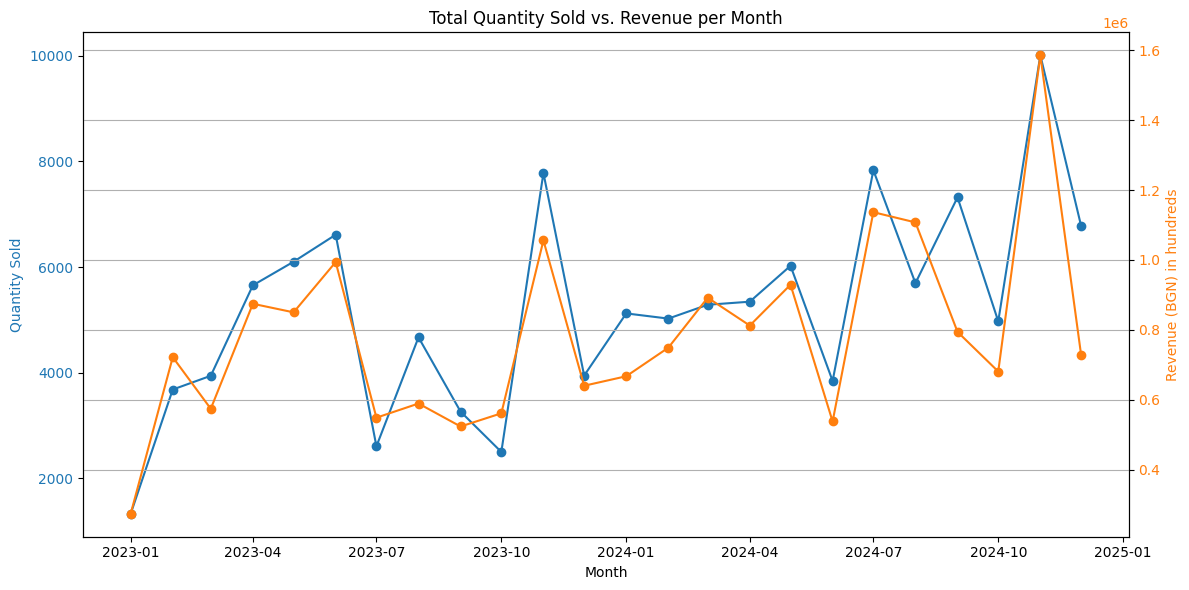

In [316]:
monthly_summary = sales_data.groupby('Month').agg({
    'Quantity': 'sum',
    'Line Amount In Base Currency': 'sum'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Quantity Sold', color=color)
ax1.plot(monthly_summary['Month'], monthly_summary['Quantity'], marker='o', color=color, label='Total Quantity Sold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Revenue (BGN) in hundreds', color=color)
ax2.plot(monthly_summary['Month'], monthly_summary['Line Amount In Base Currency'], marker='o', color=color, label='Total Revenue')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Quantity Sold vs. Revenue per Month')
fig.tight_layout()
plt.grid(True)
plt.show()

### Total Quantity Sold vs. Revenue per Month:
It is immediate that most months show a positive correlation between units sold and revenue, which in other words means that when quantity goes up, revenue also goes up. Another thing we clearly see and which we also evaluated last iteration is that every November there is a huge spike in total quantities sold and revenue. According to our stakeholder from the interview when asked about this he commented that, because it due to the wolrd wide known promotion "Black Friday" and also because of December holidays and presents, which babies also receive.

Of course there are some months, which underperform others like September and January. And again according to our stakeholder he said that these are their lowest demand months and out of all months these particilarly two always underperform. "That is why they set our goals for those months lower"- stakeholder added.

As I said we can dive deeper to analyze certain patterns we see and to do that we should see acutlaly what products/categories drive success and also products which struggle during key periods.

Let's now get to know our products even more and see which are the best-sellers during November.

November is one of the strongest months in terms of both units sold and total revenue. According to stakeholder input, this is largely driven by Black Friday promotions and holiday-related purchases. The goal here is to identify the top-performing products during this period.


/var/folders/41/d8pgsd4j1wg6_mvq030drk_00000gp/T/ipykernel_3054/1836372180.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


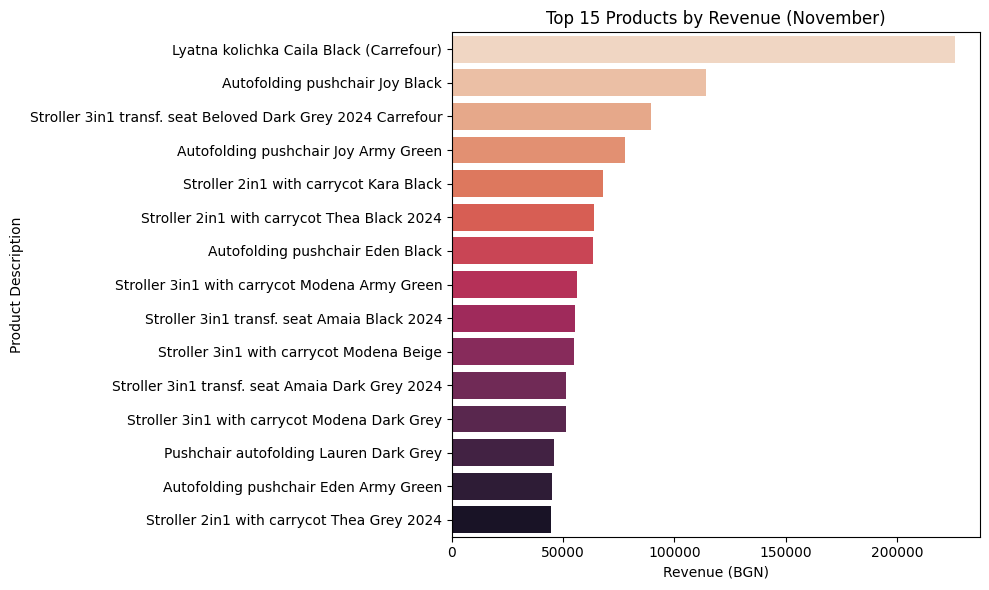

In [317]:
sales_data['Document Date'] = pd.to_datetime(sales_data['Document Date'])

november_sales = sales_data[sales_data['Document Date'].dt.month == 11]

top_november_products = (
    november_sales
    .groupby(['SKU', 'Product Description'])[['Quantity', 'Line Amount In Base Currency']]
    .sum()
    .rename(columns={'Line Amount In Base Currency': 'Revenue'})
    .sort_values(by='Revenue', ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_november_products.sort_values(by='Revenue'),
    y='Product Description',
    x='Revenue',
    palette='rocket'
)
plt.title('Top 15 Products by Revenue (November)')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.gca().invert_yaxis()  
plt.show()


- The top-selling product in November is _"Lyatna kolichka Caila Black (Carrefour)"_, selling over 2,000 units with revenue exceeding 220,000 BGN.  
- According to the stakeholder, this product is exclusive to **Carrefour Spain**, a major client, and is **heavily stocked ahead of Black Friday**.  
- Other top performers include **autofolding pushchairs** and **3in1 strollers**, which are perceived as premium gifts for babies.

Let’s evaluate how different November really is. Because the way it was looking from the first graph it could be a potential outlier month. To do that we are going to compare average quantity and revenue per product in November vs. other months (average from all as well).

,Quantity,Revenue
Is_November,,
Other Months,271.633838,40870.183611
November,98.303867,14598.245691


/var/folders/41/d8pgsd4j1wg6_mvq030drk_00000gp/T/ipykernel_3054/1532988486.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/41/d8pgsd4j1wg6_mvq030drk_00000gp/T/ipykernel_3054/1532988486.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


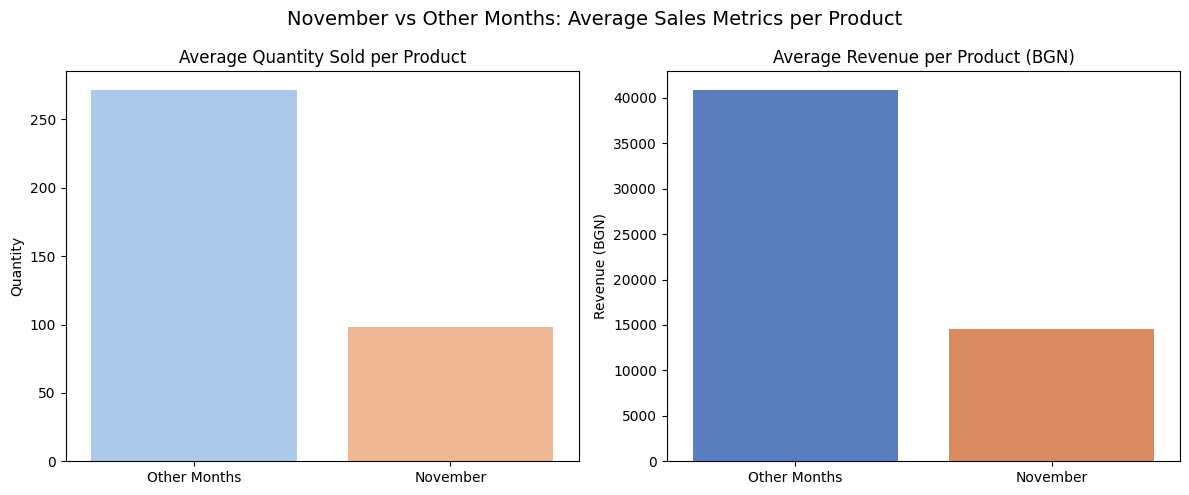

In [318]:
sales_data['Month'] = sales_data['Document Date'].dt.month
sales_data['Is_November'] = sales_data['Month'] == 11

nov_vs_other = (
    sales_data
    .groupby(['SKU', 'Is_November'])[['Quantity', 'Line Amount In Base Currency']]
    .sum()
    .rename(columns={'Line Amount In Base Currency': 'Revenue'})
    .reset_index()
)

summary = (
    nov_vs_other
    .groupby('Is_November')[['Quantity', 'Revenue']]
    .mean()
    .rename(index={True: 'November', False: 'Other Months'})
)

display(summary)
summary_plot = summary.reset_index().melt(id_vars='Is_November', var_name='Metric', value_name='Value')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sns.barplot(
    data=summary.reset_index(),
    x='Is_November',
    y='Quantity',
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title('Average Quantity Sold per Product')
axes[0].set_ylabel('Quantity')
axes[0].set_xlabel('')

sns.barplot(
    data=summary.reset_index(),
    x='Is_November',
    y='Revenue',
    ax=axes[1],
    palette='muted'
)
axes[1].set_title('Average Revenue per Product (BGN)')
axes[1].set_ylabel('Revenue (BGN)')
axes[1].set_xlabel('')

plt.suptitle('November vs Other Months: Average Sales Metrics per Product', fontsize=14)
plt.tight_layout()
plt.show()



Now we caught something interesting here. Contrary to our expectations, November has lower average sales per product in both quantity and revenue. The average quantity per product is nearly 3x higher during other months. Same for revenue — significantly higher for other months compared to November. Earlier, we saw total revenue and quantity spike in November — yet here the per-product average is lower. This can only imply **ONE** thing: More products are sold overall in November, but across more SKUs, meaning there’s broader interest across the catalog.

Each individual product sells slightly less on average, but the total rises due to increased variety of products sold.

✅ Out of this graphs we can conclude that **Black Friday** and **holiday periods** increase catalog-wide engagement and stock planning in November needs to ensure wide availability, not just of top products.

Now that we know our best-sellers in the best selling month. How about the worse selling products during January and September(the months with lowest turnover)

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display


low_months = sales_data[sales_data['Document Date'].dt.month.isin([1, 9])]
low_month_products = (
    low_months
    .groupby(['SKU', 'Product Description'])[['Quantity', 'Line Amount In Base Currency']]
    .sum()
    .rename(columns={'Line Amount In Base Currency': 'Revenue'})
    .sort_values(by='Revenue', ascending=True)  
    .head(15)  
)



low_month_products = low_month_products.reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    data=low_month_products.sort_values(by='Revenue'),
    y='Product Description',
    x='Revenue',
    palette='rocket'
)
plt.title('Bottom 15 Products by Revenue (January & September)')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'plotly'

We can see that products like adaptors and older strollers don't sell at all in slow months, because these are low priority in stocking or forecasting for Jan/Sep
Older models like "Libro Light Grey 2020" or "Catwalk Pink" barely register and Low-selling products have similar names to bestsellers. 

Maybe before we analyzed the products themselves it could've been better analyze their own representative categories.

,Quantity,Revenue
Product Group,,
100103: Bebeshki letni kolichki,83379,8994130.80
100101: Kombinirani bebeshki kolichki 3 v 1,23612,6474353.12
100102: Kombinirani bebeshki kolichki 2 v 1,9123,2906081.93
100104: Bebeshki kolichki za bliznatsi,1119,291777.11
100109: Aksesoari za kolichki,6911,146905.55
100106: Adaptori za bebeshka kolichka,1196,8952.61
100105: Obiknoveni bebeshki kolichki,18,2689.73
100108: Cybex,2,1984.33


C:\Users\User\AppData\Local\Temp\ipykernel_7444\1738624605.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


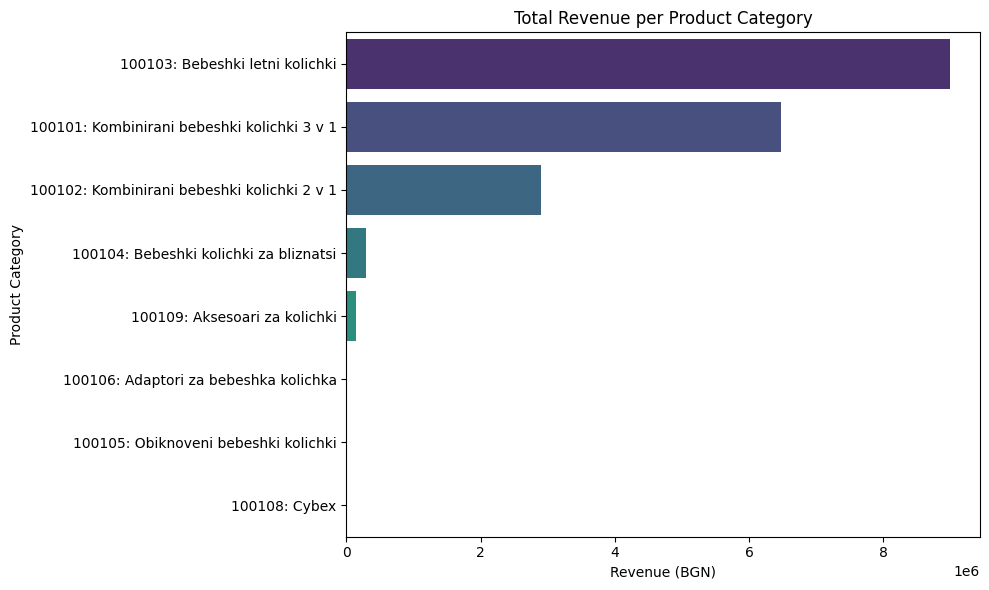

In [ ]:
category_summary = (
    sales_data
    .groupby('Product Group')[['Quantity', 'Line Amount In Base Currency']]
    .sum()
    .rename(columns={'Line Amount In Base Currency': 'Revenue'})
    .sort_values(by='Revenue', ascending=False)
)

display(category_summary)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_summary.reset_index(),
    y='Product Group',
    x='Revenue',
    palette='viridis'
)
plt.title('Total Revenue per Product Category')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()



We should immedietely get the clear things out of the way and that is indeed the three main category leaders - ``100103: Bebeshki letni kolichki`` (Summer baby strollers), Followed by ``100101 (3-in-1 strollers)`` and ``100102 (2-in-1 strollers)`` - they all dominate both quantity sold and revenue.

``100106``, ``100105``, ``100108`` contribute negligible revenue.

Some of these might be discontinued products or simply have low demand.

Now that we know our best categories we can further analyze them by plotting their montly revenue trends and see if certain categories sell better in different time periods.

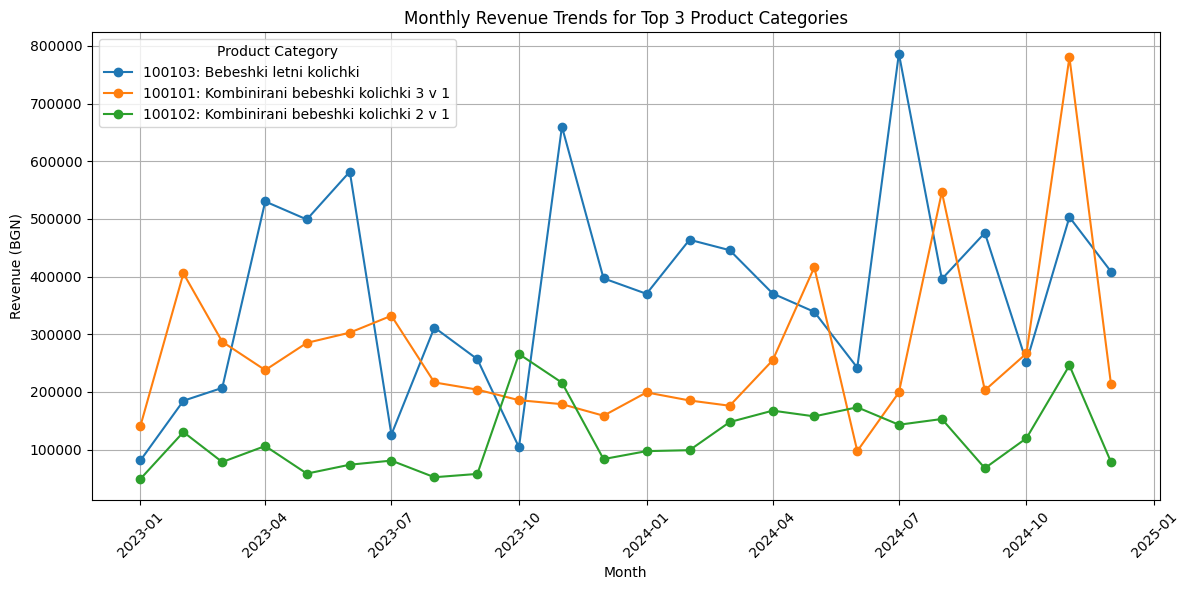

In [ ]:
import matplotlib.pyplot as plt

sales_data['Document Date'] = pd.to_datetime(sales_data['Document Date'])

sales_data['Month'] = sales_data['Document Date'].dt.to_period('M').dt.to_timestamp()

top_3_categories = ['100103: Bebeshki letni kolichki', '100101: Kombinirani bebeshki kolichki 3 v 1', '100102: Kombinirani bebeshki kolichki 2 v 1']
filtered_data = sales_data[sales_data['Product Group'].isin(top_3_categories)]

monthly_category_revenue = (
    filtered_data
    .groupby(['Month', 'Product Group'])['Line Amount In Base Currency']
    .sum()
    .reset_index()
    .rename(columns={'Line Amount In Base Currency': 'Revenue'})
)

plt.figure(figsize=(12, 6))
for group in top_3_categories:
    subset = monthly_category_revenue[monthly_category_revenue['Product Group'] == group]
    plt.plot(subset['Month'], subset['Revenue'], marker='o', label=group)

plt.title('Monthly Revenue Trends for Top 3 Product Categories')
plt.xlabel('Month')
plt.ylabel('Revenue (BGN)')
plt.xticks(rotation=45)
plt.legend(title='Product Category')
plt.tight_layout()
plt.grid(True)
plt.show()


1. Summer strollers / Bebeshki letni kolichki

Clear seasonal peaks are May–July and November. These strollers are strongly season-dependent, peaking during late spring and summer (likely for vacations, outdoor use). Notable secondary spike in November, possibly driven by Black Friday + gift season. All of this means stock levels should be increased startin in April.

2. 3-in-1 Strollers / Kombinirani bebeski kolichki 3 v 1 

More balanced demand with bumps in March–May, September–November.
These are all-season functional items (usually purchased by new parents regardless of season). Sales climb in early spring and again in fall, possibly tied to family planning trends or retailer promotions.

3. 2-in-1 Strollers / Kombinirani bebeski kolichki 2 v 1

Lowest sales and also they showcase a relatively flat trend
Possibly less preferred due to fewer features compared to 3-in-1 strollers. Likely to be price-driven or niche.



## 📃 Preprocessing 

To prepare our data for predictive modeling, we should generate features that provide temporal context and help the model learn SKU-specific sales patterns over time. Let's add them and after I am going to explain what each of those does.


In [ ]:
sales_data.head(5)

,Product Description,Document Date,Document Type,Document No,Product Group,SKU,Quantity,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Month,Week,Is_November
15182,Stroller 3in1 transf. seat Beloved Dark Grey,2023-01-04,Invoice,3710051187,100101: Kombinirani bebeshki kolichki 3 v 1,31001010118,1,1,297.02083,285.14,BGN,285.14,2023-01-01,2023-01-02,False
8010,Pushchair Juno Beige 2020,2023-01-04,Invoice,3710051199,100103: Bebeshki letni kolichki,31001030107,1,1,127.29000,127.29,BGN,127.29,2023-01-01,2023-01-02,False
2642,Stroller 2in1 with carrycot Thea Dark Grey,2023-01-04,Invoice,3720000356,100102: Kombinirani bebeshki kolichki 2 v 1,31001020110,1,1,588.68478,541.59,BGN,541.59,2023-01-01,2023-01-02,False
14751,Pushchair Beetle Beige,2023-01-04,Invoice,3710051187,100103: Bebeshki letni kolichki,31001030077,1,1,82.73958,79.43,BGN,79.43,2023-01-01,2023-01-02,False
425,Stroller 3in1 Madrid Mint Melange 2020,2023-01-04,Invoice,3720000355,100101: Kombinirani bebeshki kolichki 3 v 1,31001010135,1,1,416.07000,416.07,BGN,416.07,2023-01-01,2023-01-02,False


In [ ]:
monthly_sales = (
    sales_data
    .groupby(['SKU', 'Product Description', 'Product Group', 'Month'])
    .agg(
        Quantity=('Quantity', 'sum'),
        Revenue=('Line Amount In Base Currency', 'sum')
    )
    .reset_index()
)


In [ ]:
monthly_sales.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36


In [ ]:
monthly_sales = monthly_sales.sort_values(by=['SKU', 'Month'])

for lag in [1, 2, 3]:
    monthly_sales[f'Lag_{lag}'] = (
        monthly_sales
        .groupby('SKU')['Quantity']
        .shift(lag)
    )

monthly_sales['Rolling_Mean_3'] = (
    monthly_sales
    .groupby('SKU')['Quantity']
    .shift(1)
    .rolling(window=3)
    .mean()
    .reset_index(level=0, drop=True)
)

monthly_sales['Rolling_Mean_6'] = (
    monthly_sales
    .groupby('SKU')['Quantity']
    .shift(1)
    .rolling(window=6)
    .mean()
    .reset_index(level=0, drop=True)
)

monthly_sales['Month_Num'] = monthly_sales['Month'].dt.month
monthly_sales['Year'] = monthly_sales['Month'].dt.year

first_month = (
    monthly_sales
    .groupby('SKU')['Month']
    .transform('min')
)
monthly_sales['Is_New'] = monthly_sales['Month'] == first_month


In [ ]:
monthly_sales.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Lag_1,Lag_2,Lag_3,Rolling_Mean_3,Rolling_Mean_6,Month_Num,Year,Is_New
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,NaN,NaN,NaN,NaN,NaN,12,2024,True
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,NaN,NaN,NaN,NaN,NaN,12,2024,True
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,NaN,NaN,NaN,NaN,NaN,1,2023,True
5,31001010055,Stroller 3in1 transf. seat Darling Beige 2020,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,2,441.08,3.0,NaN,NaN,2.333333,NaN,1,2023,True
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,2.0,3.0,NaN,NaN,NaN,2,2023,False


Lag Features (`Lag_1`, `Lag_2`, `Lag_3`)
These columns represent the **quantity sold in previous months** (1 to 3 months ago). They help the model understand short-term trends like:

- Recent dips or spikes in demand
- How recent months affect the current month

Rolling Averages (`Rolling_Mean_3`, `Rolling_Mean_6`)
These features capture the **average quantity sold over the past 3 or 6 months**, excluding the current month. They help the model detect:

- Seasonality or gradual demand changes
- Smoothed out versions of volatility

Temporal Features (`Month_Num`, `Year`)
These help the model detect **seasonal patterns** across months and years. For example:

- Summer strollers may peak in warm months
- 3-in-1 strollers may sell more in colder seasons

Is_New
A boolean column that is `True` if this is the **first month the SKU appears** in the dataset. This is important because:

- New products often behave differently from mature ones
- It may help the model apply more conservative predictions for new SKUs

*Note*: Each SKU appears once **per month**, so the dataset is organized in a `SKU x Month` grid. This is intentional and correct, as our goal is to predict demand for each SKU each month.

Now let's see the correlation between those new features we added!

C:\Users\User\AppData\Local\Temp\ipykernel_7444\1115885492.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


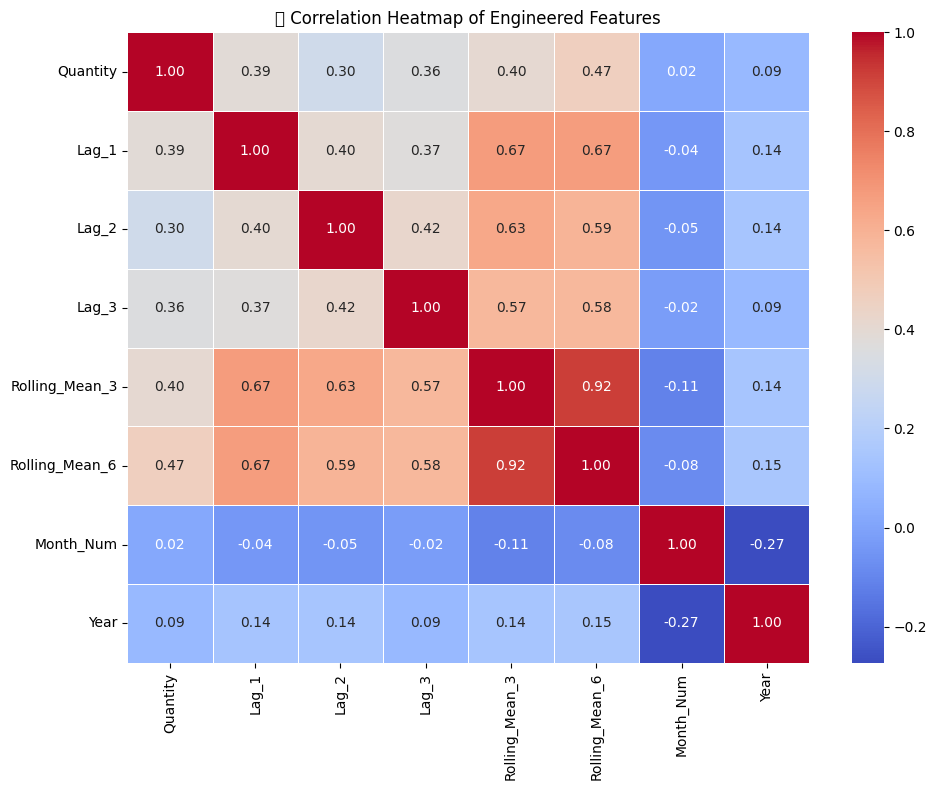

In [ ]:
numerical_cols = [
    'Quantity', 'Lag_1', 'Lag_2', 'Lag_3',
    'Rolling_Mean_3', 'Rolling_Mean_6',
    'Month_Num', 'Year'
]

correlation_data = monthly_sales[numerical_cols].dropna()

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("📊 Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()

If you go down and compare it to the previous one this one shows much more correlations between the features.

## 🪓 Splitting into train/test

In [ ]:
from sklearn.model_selection import train_test_split

model_data = monthly_sales.dropna(subset=[
    'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_6'
]) #Because lag and rolling features naturally contain NaN for the first few rows of each SKU, we need to remove them.

features = ['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_6', 'Month_Num', 'Year', 'Is_New'] #use only numerical features this iteration
target = 'Quantity'

X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 845, Testing samples: 212


## 🧪 Modelling

Once the features were engineered and cleaned (including handling NaNs due to lag and rolling operations), we can now proceed with the model training phase. The goal is to predict the monthly quantity sold of a product using its historical data (lags, rolling means, date features, etc.).

We started with a Linear Regression model as a baseline due to its simplicity and interpretability. It basically helps us understand if there's a linear relationship between features like past sales, rolling averages, and the current month's sales.

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("R²:", score)

R²: 0.24325826476419732


If we compare this result to Iteration 0, where our results for:

1. Linear Regression were R² ≈ 0.01
&
2. Decision Tree Regressor were R² ≈ 0.08

These results showed that the models were barely capturing any variance in the target variable (quantity sold), indicating poor predictive power. This was expected, as we had not yet engineered useful features like lag values, rolling averages, or seasonal components, but msot importantly we were not predicting per product, but per invoice.

And now after carefully engineering time-based features and removing noisy data (the non-invoice transactions), we re-trained the models and observe a ``Linear Regression → R² ≈ 0.25``

This is a ~25x improvement in the R² score from 0.01 → 0.25 shows that the new features — particularly Lag and Rolling Mean values — helped the model explain much more of the variance in the sales data and also now that we actually predict per products it is truly what was a game changer.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Max Error: {mae:.2f}, Mean squared error: {mse:.2f}, Root mean squared error: {rmse:.2f}")


Max Error: 50.60, Mean squared error: 13603.40, Root mean squared error: 116.63


Right off the bat we can say that:

**Max Error** - 50.60 indicates that the worst-case prediction was off by 50 units. While it’s not catastrophic in isolation, it suggests that for certain products or months, the model significantly under- or overestimated demand. These outliers could be due to:
- Sudden sales spikes (November)
- New products with no historical patterns
- Products with low or inconsistent sales history


**Mean Squared Error** - 13,603.40 meaning the model is sensitive to large errors, and this relatively high value confirms that a few large mispredictions are heavily impacting the average. It suggests our model performs well on average, but struggles with a few unpredictable cases.

**Root Mean Squared Error** - 116.63 - gives us the typical magnitude of error in the same units as our prediction target (quantity sold). An RMSE of ~117 means that, on average, the model is off by around 117 units per product-month. For products with large volume sales, this could be acceptable; however, for low-volume items, it could be a significant percentage error.

Also as I mentioned, because we did **RandomForestRegressor** in Iteration 0 let's also do it in this one.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(f"R2 Score (Random Forest): {rf_score:.4f}")

R2 Score (Random Forest): 0.2240


The Decision Tree-based models, although slightly behind, also benefited from this iteration but likely struggled due to the limited size and high variance in the data.

To further boost performance beyond individual models (Linear Regression Random Forest, maybe XGBoost), we implemented a Stacking Regressor using these three as base learners and a Ridge regression model as the meta-learner.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    # ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

meta_model = Ridge()

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

stacking_model.fit(X_train, y_train)

y_pred_stack = stacking_model.predict(X_test)

r2_stack = r2_score(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = mse_stack ** 0.5

print(f"Stacking Regressor Performance")
print(f"R²:   {r2_stack:.4f}")
print(f"MAE:  {mae_stack:.2f}")
print(f"MSE:  {mse_stack:.2f}")
print(f"RMSE: {rmse_stack:.2f}")


Stacking Regressor Performance
R²:   0.1924
MAE:  52.92
MSE:  14517.04
RMSE: 120.49


The stacking ensemble did not outperform the baseline Linear Regression model in this case (which had an R² of ~0.25). This suggests that the additional complexity introduced by the ensemble did **not translate** into better generalization on the current feature set.

Few possibilities could be that the input features may not provide enough nonlinear patterns for ensemble methods to exploit.

# 🔬 Evaluation

In [ ]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = (prediction_overview["truth"] - prediction_overview["prediction"]).abs().astype(int)

prediction_overview = prediction_overview.reset_index(drop=True)

prediction_overview.head(20)

,truth,prediction,error
0,10,26.302836,16
1,18,28.010676,10
2,45,34.428270,10
3,1,16.165009,15
4,7,17.616074,10
5,3,10.044458,7
6,1,25.407428,24
7,36,44.156743,8
8,36,29.965361,6
9,8,34.136242,26


This table summarizes the model's predictions for the first 20 samples in the test set. 
 
Some samples show large deviations (truth = 59 vs. prediction = 16), which highlights the importance of future feature improvements and error reduction strategies in upcoming iterations.

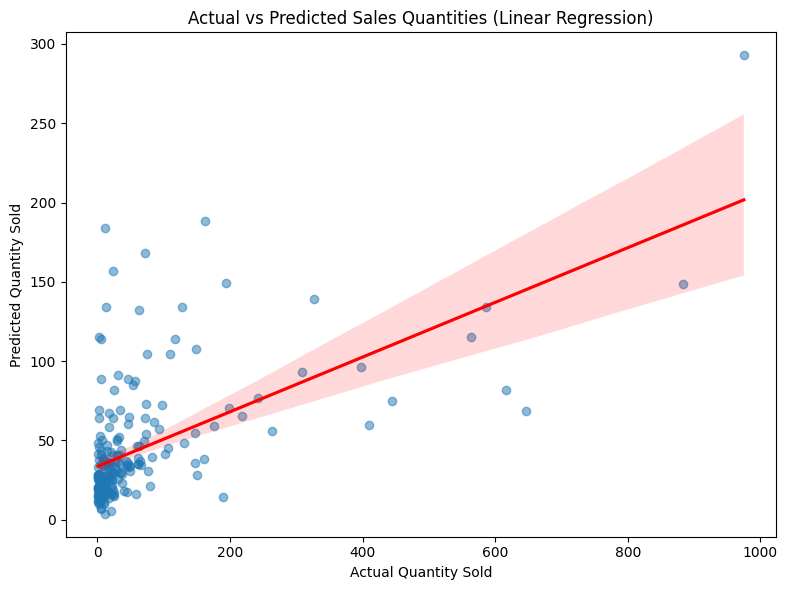

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel('Actual Quantity Sold')
plt.ylabel('Predicted Quantity Sold')
plt.title('Actual vs Predicted Sales Quantities (Linear Regression)')
plt.tight_layout()
plt.show()


It is first important to say what kind of information this graph gives. The blue dots are actual data points and depending on how far they are from the red line, the model accurately predicts them. In other words if one dot is closer to the red line the model predicts it more accurately.

While the model has learned a basic relationship between past sales and future demand, its performance is still limited by variance and outliers. 

These findings support the decision to enhance modeling in future iterations by:

1. Incorporating product-specific features (category, seasonality).
2. Trying more robust algorithms or other ensemble techniques.
3. Possibly adding stock availability or promotion periods as features.

say that i did change scatter plot but it did not help

## 📌 Final Conclusion - Iteraton 1

What went well:
1. Forecasting per Product per Month Achieved
We successfully transitioned from invoice-level predictions to aggregated monthly forecasting per product, aligning with the goal of improving inventory planning.
2. Feature Engineering Enhanced Predictive Power
By introducing lag features, rolling averages, and seasonality indicators, we improved the model’s ability to capture historical patterns and trends. This boosted the R² score from ~0.01 in Iteration 0 to ~0.25 with Linear Regression.
3. Model Evaluation Pipeline Established
We implemented a robust train/test split, model training, and evaluation pipeline with metrics including MAE, MSE, RMSE, and R², along with visual diagnostics like regplot.

Challenges & Limitations:
1. Limited Dataset Size and Sparsity
Due to short sales history or inconsistent product launches, many rows (especially for new SKUs) had to be dropped, reducing sample size and generalization ability.

2. Weak Correlation Among Features
While engineered features improved model performance, their correlation with the target variable remained moderate. This indicates the need for external factors (e.g. promotions, stock levels, price discounts) to improve accuracy.

3. Ensemble Models Didn't Outperform Linear Regression
Surprisingly, more complex models like Random Forest, XGBoost, and Stacking Regressor underperformed compared to basic Linear Regression, suggesting the need for more diverse and predictive features.


Iteration 1 was a strong step forward:
We moved from foundational setup to a working forecasting model at the product level, established a clean modeling pipeline, and began interpreting temporal trends in the data. While accuracy is still moderate, this iteration laid a solid base for integrating more contextual data and constraints 
in Iteration 2 to further boost performance.

---

<h1 style="font-size:300%">Iteration 0 - Blueprint</h1>

# 📦 Data Provisioning

In this step we are going to provide the inital data that is going to be used for iteration 0, which is only sales from 01.01.2023 - 01.01.2025. Those exact dates were chosen, because after a discussion with the stakeholder, it was reviewed that the company showed most growth during this period of time and has most data to work with.


In [ ]:
sales_data = pd.read_csv("sales_strollers_01012023_01012025.csv", encoding="utf-8", delimiter=";")
sales_data.sample(5)

,Document Date,Customer,Номер на клиентска поръчка (Ред от продажба),Document No,Ред от продажба/Държава на произход на клиент,Склад от шапката на документ от тип складова разписка,Product,Product Description,Quantity,Quantity Unit,Quantity Base,Unit Price,Line Amount In Base Currency,Sales Order,Sales Person Group Name,Customer Purchase Order No,Document Type,Enterprise Company Location
964,15.11.2024,DZhULIANIS OOD,2000037526,3710074193,БЪЛГАРИЯ,1415 ПЛОВДИВ КИКА ГРУП - ОКОЛОВРЪСТЕН ПЪТ,31001030165,Pushchair Sarah Grey 2023,1,pcs,1,"117,87","117,87",041:1710162069 - Porachka ot klient,Пловдив,2000037526,Invoice,"KIKA GROUP LTD, HEAD OFFICE"
5564,5.7.2024,HIPOLEND AD,ПРЧ000000397534,3710069724,БЪЛГАРИЯ,1415 ПЛОВДИВ КИКА ГРУП - ОКОЛОВРЪСТЕН ПЪТ,31001030159,Pushchair Cloe Grey 2024,1,pcs,1,"145,71","145,71",041:1710152625 - Porachka ot klient,Пловдив,ПРЧ000000397534,Invoice,"KIKA GROUP LTD, HEAD OFFICE"
12758,30.10.2023,HIPOLEND AD,ПВС2685/20.10.2023,3710061481,БЪЛГАРИЯ,1406 ПЛОВДИВ КИКА ГРУП,31001010143,Stroller 3 in 1 Ugo Dark Grey Melange 2020,-1,pcs,-1,"342,43617","-321,89",054:1710008758 - Return goods,Пловдив,ПВС2685/20.10.2023,Credit Note,"KIKA GROUP LTD, HEAD OFFICE"
5380,10.7.2024,G.KALESIS-CH.STOGGIANI EE,NaN,3710069832,GREECE\r\n,1415 ПЛОВДИВ КИКА ГРУП - ОКОЛОВРЪСТЕН ПЪТ,31001030172,Pushchair Beetle Black 2023,2,pcs,2,"40,03684","148,78",042:1710152856 - Porachka ot klient bez DDS,Външен пазар,NaN,Invoice,"KIKA GROUP LTD, HEAD OFFICE"
1355,7.11.2024,BEBE MAISON CAMERON CHRISTINA SIA EE,NaN,3710073897,GREECE\r\n,1415 ПЛОВДИВ КИКА ГРУП - ОКОЛОВРЪСТЕН ПЪТ,31001010250,Stroller 3in1 transf. seat Darling Army Green ...,2,pcs,2,"138,375","541,28",042:1710161055 - Porachka ot klient bez DDS,Външен пазар,NaN,Invoice,"KIKA GROUP LTD, HEAD OFFICE"


After loading the data from the csv file, it is immediately apparent that the dataset contains a lot of necessary and unnecessary information. Nevertheless a little bit of fixing is needed to make it work. Additionally, because the data does not give any trends and does not show any ways we can work with it we are going to visualize the data in the next step.

## 📈 Visualizations and sampling data


With the help of those graphs we can visualzie the data way more easily and make future decisions.

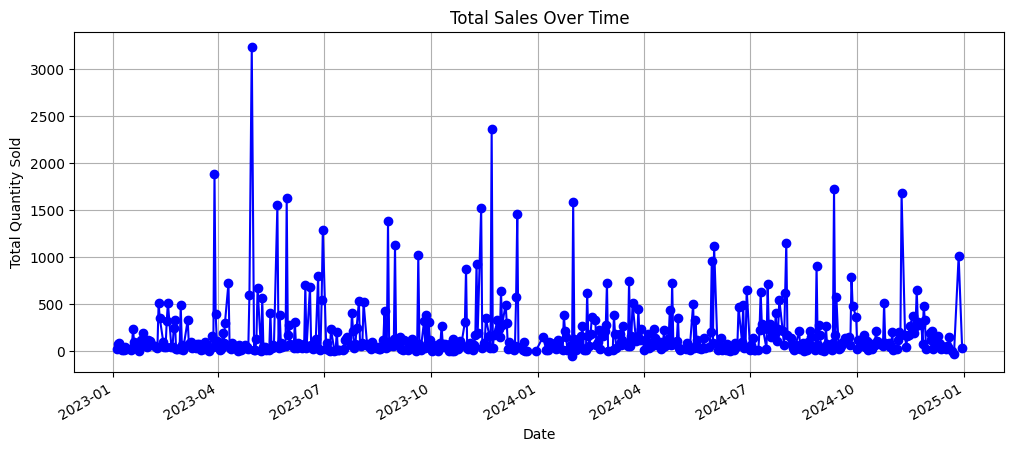

In [ ]:
sales_data['Document Date'] = pd.to_datetime(sales_data['Document Date'], dayfirst=True)

# Total Sales Over Time
plt.figure(figsize=(12, 5))
sales_data.groupby('Document Date')['Quantity'].sum().plot(kind='line', marker='o', color='b')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.grid()
plt.show()

### 1. Total Sales Over Time (First Graph)

From the first grap we can analyze that there are frequent demand spikes, due to their way of business (B2B or wholesaling). Also we can clearly see that some months have higher peaks than other, indicating that sales are not evenly distributed.

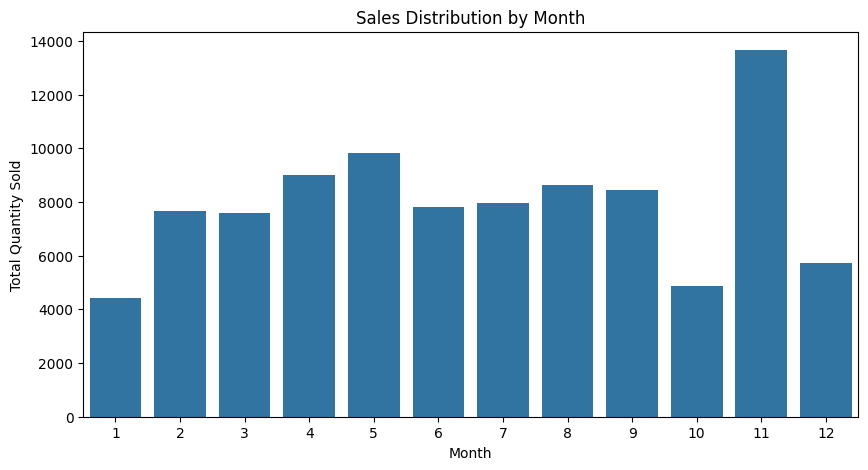

In [ ]:
# Sales Distribution by Month
sales_data['month'] = sales_data['Document Date'].dt.month
monthly_sales = sales_data.groupby('month')['Quantity'].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.show()

### 2.  Sales Distribution by Month (Second Graph)

From this graph we can acknowledge that during november most growth is being shown due to the demand before winter holidays (Also Black Friday and other promotions during this period play significant role)
January and October are particularly lower on sales possibly, because of seasonality trends.
To sum up also sales are spread out across the year, but certain months have noticeable dips.

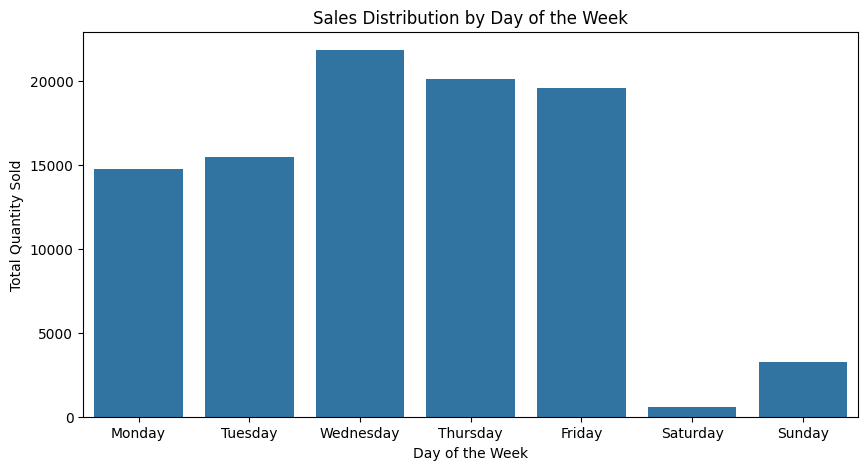

In [ ]:
# Sales Distribution by Day of the Week
sales_data['day_of_week'] = sales_data['Document Date'].dt.dayofweek
weekday_sales = sales_data.groupby('day_of_week')['Quantity'].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            y=weekday_sales.values)
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.show()

### 3. Sales Distribution by Day of the Week

This graph does not also bring any big surprises. Due to the company again being oriented towards wholesales, which means other business buy from them and as it is gloablly known that Saturday and Sunday are not workdays and nobody operates much on weekends.

Also sales are almost evenly spread throughout the whole week.

## 📃 Preprocessing 

In this part of the notebook we are going to remove unnecessary columns that are not needed for iteration 0, hanlde missing values, but not in the Quantity part, where we have negative values, but does that not mean that there are any issues, but they are pre-orders, when the company hasn't had stock, but still made a sale.For this reason we are going to add also a new column `pre_order_flag` to mark those sales and also convert them to positive sales, becuase there are still sales.
The other relevant columns are `Document Date` (Date of sale), `Product`(SKU - identification number), `Product Description`(Name) `Quantity`and additionally we are going to create other potentially useful features from Document Date like `year`, `month`, `week`, `day of the week` and `is_weekend`.

In [ ]:
sales_data['Document Date'] = pd.to_datetime(sales_data['Document Date'], dayfirst=True)

sales_data['pre_order_flag'] = sales_data['Quantity'].apply(lambda x: 1 if x < 0 else 0)
sales_data['Quantity'] = sales_data['Quantity'].abs()
sales_data = sales_data[['Document Date', 'Product', 'Product Description', 'Quantity', 'pre_order_flag']]

sales_data['year'] = sales_data['Document Date'].dt.year
sales_data['month'] = sales_data['Document Date'].dt.month
sales_data['week'] = sales_data['Document Date'].dt.isocalendar().week
sales_data['day_of_week'] = sales_data['Document Date'].dt.dayofweek
sales_data['day_of_month'] = sales_data['Document Date'].dt.day
sales_data['is_weekend'] = sales_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print("\nPre-Orders (Negative Values Converted to Positive):")
print(sales_data[sales_data['pre_order_flag'] == 1].head())

print("\nMissing values after preprocessing:")
print(sales_data.isnull().sum())

sales_data.sample(5)


Pre-Orders (Negative Values Converted to Positive):
   Document Date      Product                             Product Description  \
15    2024-12-23  31001030154                Autofolding pushchair Eden Black   
16    2024-12-23  31001030175                      Pushchair Beetle Mint 2023   
17    2024-12-23  31001020128  Stroller 2in1 with plastic carrycot Amani Pink   
18    2024-12-23  31001030179                           Pushchair Alexa Black   
19    2024-12-23  31001030148                      Pushchair Miley Black 2023   

    Quantity  pre_order_flag  year  month  week  day_of_week  day_of_month  \
15         5               1  2024     12    52            0            23   
16         2               1  2024     12    52            0            23   
17         1               1  2024     12    52            0            23   
18         4               1  2024     12    52            0            23   
19         4               1  2024     12    52            0          

,Document Date,Product,Product Description,Quantity,pre_order_flag,year,month,week,day_of_week,day_of_month,is_weekend
7716,2024-04-10,31001030172,Pushchair Beetle Black 2023,1,0,2024,4,15,2,10,0
2719,2024-09-26,31001090005,Stroller raincover,2,0,2024,9,39,3,26,0
3954,2024-08-07,31001030152,Autofolding pushchair Ciela Black,5,0,2024,8,32,2,7,0
10141,2024-02-07,31001030152,Pushchair Ciela Black,1,0,2024,2,6,2,7,0
14367,2023-08-18,31001010231,Stroller 3in1 transf. seat Darling Beige 2023,1,0,2023,8,33,4,18,0


# 💡 Feature selection
After setting up our data set we need to select our features for the model and to do that we are going to generate a correleation heatmap to see relationships between sales and features and alse see the weak features we added.

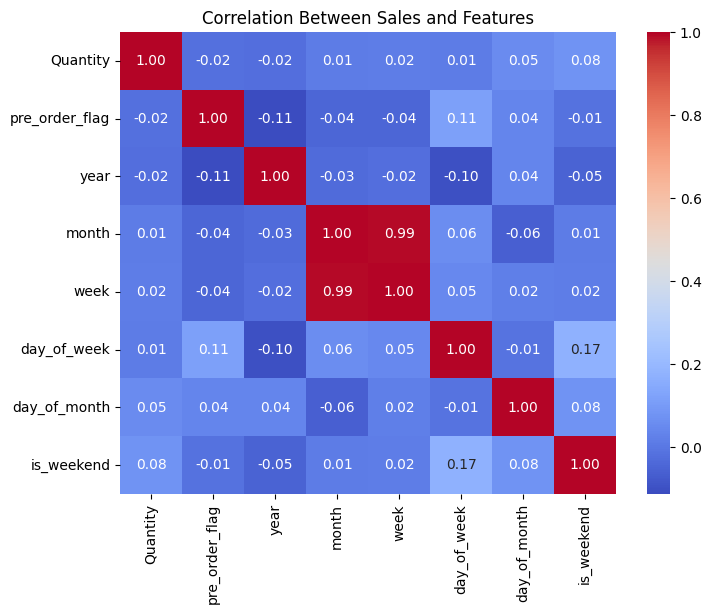

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_features = ['Quantity', 'pre_order_flag', 'year', 'month', 'week', 'day_of_week', 'day_of_month', 'is_weekend']


correlation_matrix = sales_data[correlation_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Between Sales and Features')
plt.show()


From the heamap we can conclude that all features have low correlation (< 0.1) with Quantity. This means that none of the current time-based features strongly predict sales, which for the purpose of iteration is acceptable, because with this first version of the model we are just setting up everything fro future improvements. `month` and `week` are almost perfectly correlated (0.99), but we only need one of them, not both.`day_of_week` and `is_weekend` also have some correlation (0.17). The rest have weak correlations (< 0.1) with sales and currently they won't be useful alone, but of course in the future they could be used to improve the model.

In [ ]:
selected_features = ['month', 'day_of_week', 'is_weekend', 'pre_order_flag']
X = sales_data[selected_features]
y = sales_data['Quantity']

## 🪓 Splitting into train/test

Now that we have identified the features for this iteration we are going to split our dataset into train/test sets. Additionally it is most important to mention our target variable, which is `Quantity`.

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 20000 observations, of which 16000 are now in the train set, and 4000 in the test set.


# 🧪 Modelling

Next up on the board is modelling. As mentioned in the analytical approach part of the proposal we are going to Decision Trees for this model, because it handles non-linear relationships, which is one the reasons mentioned there.

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Sample Predictions vs. Actual Sales:")
print(pd.DataFrame({"Actual": y_test[:10].values, "Predicted": y_pred[:10]}))

score = model.score(X_test, y_test)
print("R² Score (Accuracy):", score)


Sample Predictions vs. Actual Sales:
   Actual  Predicted
0       5   4.120916
1       1   5.422084
2       1   4.435798
3       2   5.551954
4       1   5.281186
5       4   5.574011
6       1   5.703880
7       1   5.248100
8       1   4.142973
9       1   4.446826
R² Score (Accuracy): 0.012886231176235441


In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Sample Predictions vs. Actual Sales:")
print(pd.DataFrame({"Actual": y_test[:10].values, "Predicted": y_pred[:10]}))
score = model.score(X_test, y_test)
print("Accuracy:", score)


Sample Predictions vs. Actual Sales:
   Actual  Predicted
0       5   1.677083
1       1   3.760797
2       1   2.624365
3       2   7.119843
4       1   3.919003
5       4   5.931624
6       1   8.956522
7       1   6.309735
8       1   3.852853
9       1   5.746835
Accuracy: 0.08106811701625627


From this short report from above we can conclude that predictions are close to actual values or in a reasonable range compared to actual values, however some predictiosn are higher or lower than expected, which is expected due to limited features. One big problem, which is a priority in future iterations is accuaracy. Only `0.081` is not going to do the job. It is too low to be acceptable, but since as we said this is only <b>Iteration 0</b>, where we are working on just setting up the model. It is going to be improved in future iterations.

To get a better visualization we are going to also show the tree itself.

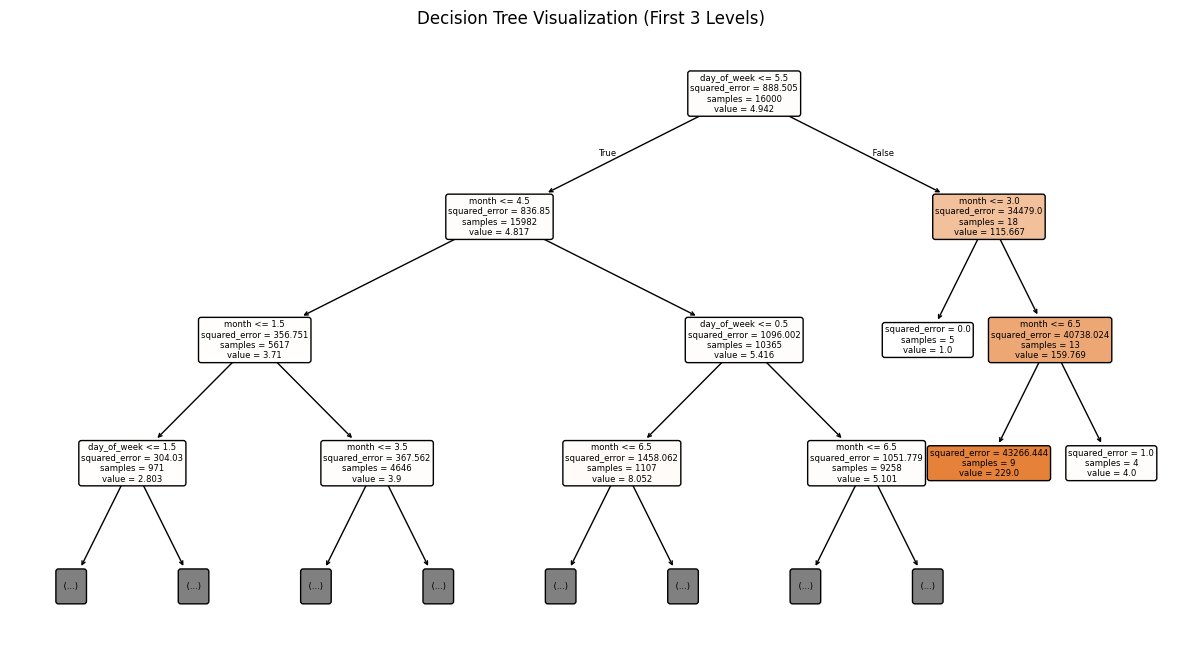

In [ ]:
from sklearn.tree import plot_tree


plt.figure(figsize=(15, 8))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

Thanks to plotting the tree we can clearly how the model operates and how he splits first on `day_of_week` and `month`, meaning those are the most important features. Some branches lead to very high sales values, which might indicate overfitting to specific cases.
Overally the tree’s structure seems logical but limited by weak feature correlations.


# 🏫 BUY / DO NOT BUY Classification

For experimenting purposes, we are going to convert predictions into "BUY" or "DON'T BUY" and for this we are going to use the <b>median quantity sold</b> as the threshold. The final version of course is to predict exactly the amount of what needs to ordered more from, but becuase for this iteration our keyword is simplicity, we can use binary recommendations just for this iteration.

In [ ]:
import numpy as np


threshold = np.median(y_train)
buy_dont_buy = ["Buy" if pred > threshold else "Don't Buy" for pred in y_pred]

classification_results = pd.DataFrame({
    "Actual Sales": y_test.values,
    "Predicted Sales": y_pred,
    "Recommendation": buy_dont_buy
})

print("\nSample Classification Results:")
print(classification_results.head(10))


Sample Classification Results:
   Actual Sales  Predicted Sales Recommendation
0             5         1.677083            Buy
1             1         3.760797            Buy
2             1         2.624365            Buy
3             2         7.119843            Buy
4             1         3.919003            Buy
5             4         5.931624            Buy
6             1         8.956522            Buy
7             1         6.309735            Buy
8             1         3.852853            Buy
9             1         5.746835            Buy


# 🔬 Evaluation

Now we are going to run some classifications report so we can see what should be improved moving on.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 5.5578478452603965
Root Mean Squared Error (RMSE): 27.940682201196925


In [ ]:
from sklearn.metrics import classification_report

threshold = np.median(y_train)  
actual_labels = ["Buy" if y > threshold else "Don't Buy" for y in y_test]
predicted_labels = ["Buy" if y > threshold else "Don't Buy" for y in y_pred]  

report = classification_report(actual_labels, predicted_labels)
print("\nClassification Report for Iteration 0:")
print(report)



Classification Report for Iteration 0:
              precision    recall  f1-score   support

         Buy       0.43      1.00      0.60      1694
   Don't Buy       0.92      0.01      0.03      2306

    accuracy                           0.43      4000
   macro avg       0.67      0.51      0.31      4000
weighted avg       0.71      0.43      0.27      4000



From the first report, where we get the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE) we can easily say two things:
1. Model predictions deviate by ~5.5 strollers on average.
2. Some predictions have larger errors, confirming a lack of strong predictive features.

From the second report we get the performance of distinguishing between "Buy" and "Don't Buy". As a start we see `1.00` on the reacll of "Buy", which indicates that the model predicts "Buy" too often and almost none times the other option - "Don't Buy".
All of this means that the precision is unbalanced, which confirms feature limitations in distinguishing real demand fluctuations.


## 📌 Final Conclusion for Iteration 0

What Went Well:
1. The decision tree model functions correctly and is interpretable.
2. Time-based features segmented data, but with weak impact.
3. The classification system is in place, setting up future improvements.

Challenges & Limitations:
1. Low correlation between features and sales.
2. Overfitting risk, because the model memorizes data patterns instead of generalizing well.
3. Imbalanced Buy/Don't Buy logic, which suggest tha the model needs better decision thresholds based on stock levels.

Iteration 0 serves as out foundational baseline. The model is not yet accurate but provides structure for future iterations. By adding stronger features and refining decision logic, we will progressively improve stock forecasting accuracy in Iteration 1.

## 📌 Final Conclusion from all Iterations
